## Import libraries

In [37]:
import os
import gc
import sys
import time
import math
import numpy as np
import pandas as pd
notebookstart= time.time()

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [39]:
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import CSVLogger, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [40]:
#use this command to install Keras tuner
#installing the required libraries
!pip install keras-tuner
from keras_tuner import RandomSearch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Data

In [41]:
storename = input('Enter the store name for which cyou want a forecast\n')

Enter the store name for which cyou want a forecast
CA_1


In [42]:
#Load data
filename = storename+'_sales_data.csv'
#df = pd.read_csv(filename, index_col = 'date')
df = pd.read_csv(filename, index_col=[0])
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
df.head()

DataFrame Shape: 1951 rows, 20 columns


,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,cpi,unemployment_rate,gas_price,snap_ca,ca_walmart,ca_hobbies,ca_household,ca_foods,store_sales,median_price,min_price,max_price
2011-01-29,11101,1,1,2011,None,None,None,None,221.187,9.1,3.163,0,39.50,20.14,36.5,63.00,4337.0,3.18,0.2,20.0
2011-01-30,11101,2,1,2011,None,None,None,None,221.187,9.1,3.163,0,42.50,30.02,29.0,67.90,4155.0,3.18,0.2,20.0
2011-01-31,11101,3,1,2011,None,None,None,None,221.187,9.1,3.155,0,36.50,22.42,48.0,60.90,2816.0,3.18,0.2,20.0
2011-02-01,11101,4,2,2011,None,None,None,None,221.898,9.0,3.155,1,42.40,19.08,38.5,62.70,3051.0,3.18,0.2,20.0
2011-02-02,11101,5,2,2011,None,None,None,None,221.898,9.0,3.155,1,38.69,21.96,35.2,57.42,2630.0,3.18,0.2,20.0


# Preprocess data

In [43]:
# Check for null values
print(df.isna().any())

wm_yr_wk             False
wday                 False
month                False
year                 False
event_name_1         False
event_type_1         False
event_name_2         False
event_type_2         False
cpi                  False
unemployment_rate    False
gas_price            False
snap_ca              False
ca_walmart           False
ca_hobbies           False
ca_household         False
ca_foods             False
store_sales           True
median_price         False
min_price            False
max_price            False
dtype: bool


In [44]:
df = df.dropna()
print(df.isnull().any())

wm_yr_wk             False
wday                 False
month                False
year                 False
event_name_1         False
event_type_1         False
event_name_2         False
event_type_2         False
cpi                  False
unemployment_rate    False
gas_price            False
snap_ca              False
ca_walmart           False
ca_hobbies           False
ca_household         False
ca_foods             False
store_sales          False
median_price         False
min_price            False
max_price            False
dtype: bool


### One-hot encoding on categorical variables using pd.dummies

In [45]:
df = pd.get_dummies(df, columns = ["event_type_1", 'event_name_1', 'event_name_2',	'event_type_2'])
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))

DataFrame Shape: 1941 rows, 60 columns


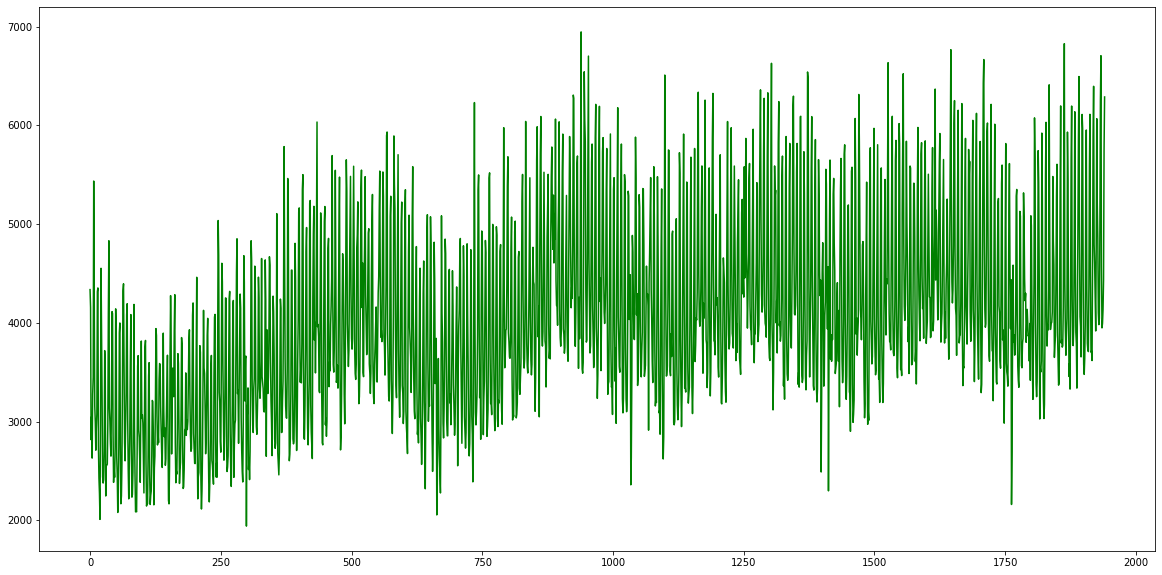

In [46]:
plt. figure(figsize=(20,10))
plt.plot(np.arange(0, len(df['store_sales'])), df['store_sales'], 'g', label="historic sales")
#plt.plot(df.index, df['store_sales'])

In [47]:
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))

DataFrame Shape: 1941 rows, 60 columns


In [48]:
df_train = df.copy()

In [49]:
FEATURES = df.columns.values 
FEATURES

array(['wm_yr_wk', 'wday', 'month', 'year', 'cpi', 'unemployment_rate',
       'gas_price', 'snap_ca', 'ca_walmart', 'ca_hobbies', 'ca_household',
       'ca_foods', 'store_sales', 'median_price', 'min_price',
       'max_price', 'event_type_1_Cultural', 'event_type_1_National',
       'event_type_1_None', 'event_type_1_Religious',
       'event_type_1_Sporting', 'event_name_1_Chanukah End',
       'event_name_1_Christmas', 'event_name_1_Cinco De Mayo',
       'event_name_1_ColumbusDay', 'event_name_1_Easter',
       'event_name_1_Eid al-Fitr', 'event_name_1_EidAlAdha',
       "event_name_1_Father's day", 'event_name_1_Halloween',
       'event_name_1_IndependenceDay', 'event_name_1_LaborDay',
       'event_name_1_LentStart', 'event_name_1_LentWeek2',
       'event_name_1_MartinLutherKingDay', 'event_name_1_MemorialDay',
       "event_name_1_Mother's day", 'event_name_1_NBAFinalsEnd',
       'event_name_1_NBAFinalsStart', 'event_name_1_NewYear',
       'event_name_1_None', 'event_name_

### Min-Max scaling
All the columns in the data frame are on a different scale. Now we will scale the values to -1 to 1 for faster training of the models.

In [50]:
def prepare_data(df):
    df_filter = df[FEATURES]
    np_filter_unscaled = np.array(df_filter)
    print(np_filter_unscaled.shape)
    np_c_unscaled = np.array(df['store_sales']).reshape(-1, 1)
    return np_filter_unscaled, np_c_unscaled
    
np_filter_unscaled, np_c_unscaled = prepare_data(df_train)
scaler_train = MinMaxScaler()
np_scaled = scaler_train.fit_transform(np_filter_unscaled)
scaler_pred = MinMaxScaler()
np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)   

(1941, 60)


In [51]:
# Set the input_sequence_length length - this is the timeframe used to make a single prediction
input_sequence_length = 10
# The output sequence length is the number of steps that the neural network predicts
output_sequence_length = 30 #

index_store_sales = df_train.columns.get_loc("store_sales")
train_data_length = 1881
train_data = np_scaled[:train_data_length, :]
test_data = np_scaled[train_data_length - input_sequence_length:, :]

In [52]:
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    #print(data_len)
    #print(input_sequence_length)
    #print(output_sequence_length)
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) 
        y.append(data[i:i + output_sequence_length, index_store_sales]) 
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data

In [53]:
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)


In [54]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(1841, 10, 60) (1841, 30)
(30, 10, 60) (30, 30)


<function matplotlib.pyplot.show(*args, **kw)>

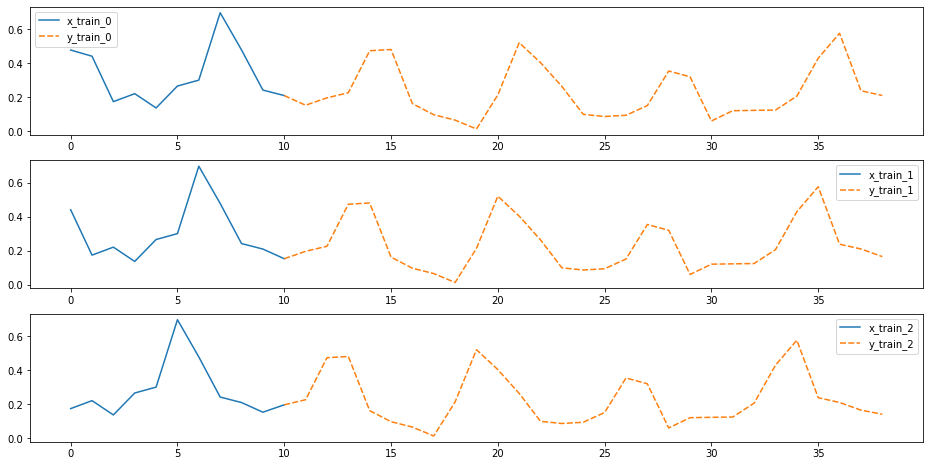

In [55]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
nrows = 3 # number of shifted plots
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(16, 8))
for i, ax in enumerate(fig.axes):
    xtrain = pd.DataFrame(x_train[i][:,index_store_sales], columns={f'x_train_{i}'})
    ytrain = pd.DataFrame(y_train[i][:output_sequence_length-1], columns={f'y_train_{i}'})
    ytrain.index = np.arange(input_sequence_length, input_sequence_length + output_sequence_length-1)
    xtrain_ = pd.concat([xtrain, ytrain[:1].rename(columns={ytrain.columns[0]:xtrain.columns[0]})])
    df_merge = pd.concat([xtrain_, ytrain])
    sns.lineplot(data = df_merge, ax=ax)
plt.show

# Model


*   Hyper parameters : Learning rate, Number of neurons, Number of LSTM layers.

*   Used random search for hyper parameter tunning.



In [56]:
def build_model(hp):      
    model = Sequential()
    n_output_neurons = output_sequence_length
    #model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units=hp.Int('num_of_neurons',min_value=32,max_value=512,step=32), return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(20))
    model.add(Dense(n_output_neurons))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])), loss='mse')

    return model

In [57]:
#feeding the model and parameters to Random Search
tuner=RandomSearch(build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner1',
    project_name='Timeseries')

In [58]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_of_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [59]:
#fitting the tuner on train dataset
tuner.search(x_train, y_train,epochs=10,validation_data=(x_test, y_test))

In [60]:
tuner.results_summary()

Results summary
Results in tuner1/Timeseries
Showing 10 best trials
Trial summary
Hyperparameters:
num_of_neurons: 128
learning_rate: 0.01
Score: 0.005147737450897694
Trial summary
Hyperparameters:
num_of_neurons: 96
learning_rate: 0.01
Score: 0.005308926105499268
Trial summary
Hyperparameters:
num_of_neurons: 384
learning_rate: 0.0001
Score: 0.02312240314980348
Trial summary
Hyperparameters:
num_of_neurons: 224
learning_rate: 0.0001
Score: 0.030303582549095154
Trial summary
Hyperparameters:
num_of_neurons: 160
learning_rate: 0.0001
Score: 0.031330445781350136


In [61]:
best_model = tuner.get_best_models()[0]

In [62]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               96768     
                                                                 
 dense (Dense)               (None, 20)                2580      
                                                                 
 dense_1 (Dense)             (None, 30)                630       
                                                                 
Total params: 99,978
Trainable params: 99,978
Non-trainable params: 0
_________________________________________________________________


# Sales Prediction & Evaluation

In [63]:
# Get the predicted values
y_pred_scaled = best_model.predict(x_test)
#print(len(y_pred_scaled))

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)

metrics = {}
metrics['R2 score'] = round(r2_score(y_test_unscaled, y_pred),3)
#metrics['RMSPE'] = np.sqrt(np.mean(np.square(((y_test_unscaled - y_pred) / y_test_unscaled)), axis=0))
metrics['RMSE'] = round(np.sqrt(mean_squared_error(y_test_unscaled, y_pred)),3)
metrics['MAPE'] = round(mean_absolute_percentage_error(y_test_unscaled, y_pred),3)

print('Evaluation merics:', metrics)

with open(storename+'metrics.txt', 'w') as file1: 
      file1.write(str(metrics))


def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_store_sales]).rename(columns={0:'History'})
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'Truth'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'Prediction'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    return df_merge_


batch_number = 50
x_test_unscaled_df, y_pred_df, y_test_unscaled_df = prepare_df(i, x_test, y_test, y_pred)
title = f"{storename}: Actual vs Predictions"
alldata = plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title) 


Evaluation merics: {'R2 score': 0.859, 'RMSE': 343.757, 'MAPE': 0.056}


In [64]:
alldata.Prediction.fillna(alldata.History, inplace=True)
alldata.Truth.fillna(alldata.History, inplace=True)
alldata['date'] = pd.date_range(start='2016-04-13', periods=len(alldata), freq='D')
alldata = alldata.set_index('date')

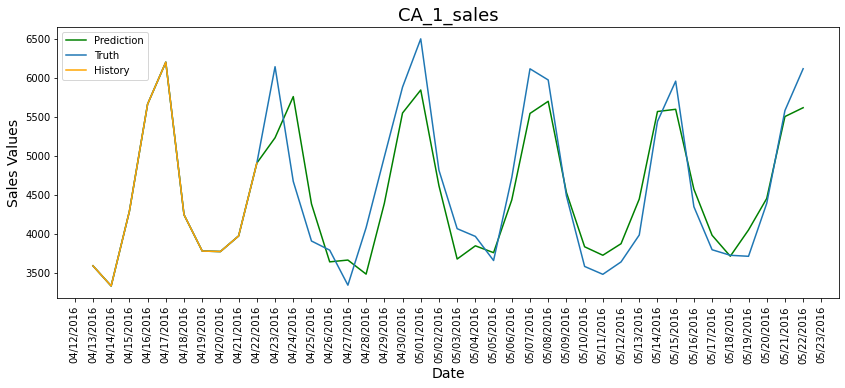

In [65]:
# Plot the data
plt.figure(figsize=(14, 5))
ax = sns.lineplot(x=alldata.index, y=alldata['Prediction'], label = 'Prediction', color = 'green')
ax = sns.lineplot(x=alldata.index, y=alldata['Truth'], label = 'Truth', color = '#1f77b4')
ax = sns.lineplot(x = alldata.index[:10], y = alldata['History'][:10], label = 'History', color = '#FFA500')

#ax.axvline(alldata.index[9], color ='black', linestyle='--', lw = 1, alpha = 0.75, label = 'breakpoint')
# Define the date format
date_form = DateFormatter("%m/%d/%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Sales Values', fontsize=14)
ax.set_title(storename + '_sales', fontsize=18)
plt.legend(loc="best")

plt.savefig(storename+ '_sales_pred.png')

In [66]:
LSTM_result = y_pred_df.copy()
LSTM_result['date'] = pd.date_range(start='2016-04-23', periods=len(LSTM_result), freq='D')
newname = storename + '_sales'
LSTM_result.rename(columns={'Prediction': newname}, inplace=True)
LSTM_result.to_csv(storename+'prediction.csv')

# Sales Forecasting using best model

In [67]:
# Get the latest input batch from the test dataset, which is contains the price values for the last ten trading days
x_test_latest_batch = np_scaled[-11:-1,:].reshape(1,10,60)

# Predict on the batch
y_pred_scaled = best_model.predict(x_test_latest_batch)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred_scaled)

# Prepare the data and plot the input data and the predictions
x_test_unscaled_df, y_test_unscaled_df, _ = prepare_df(0, x_test_latest_batch, '', y_pred_unscaled)
forecastdata = plot_multi_test_forecast(x_test_unscaled_df, '', y_pred_df, f"{storename}: history Vs. forecaste")

#forecastdata

In [68]:
LSTM_forecast = pd.DataFrame()
LSTM_forecast['Forecast'] = forecastdata['Prediction']
LSTM_forecast['date'] = pd.date_range(start='2016-05-23', periods=len(LSTM_forecast), freq='D')
LSTM_forecast.to_csv(storename+'forecast.csv')

In [69]:
forecastdata.Prediction.fillna(forecastdata.History, inplace=True)
forecastdata['date'] = pd.date_range(start='2016-05-13', periods=len(forecastdata), freq='D')
forecastdata = forecastdata.set_index('date')

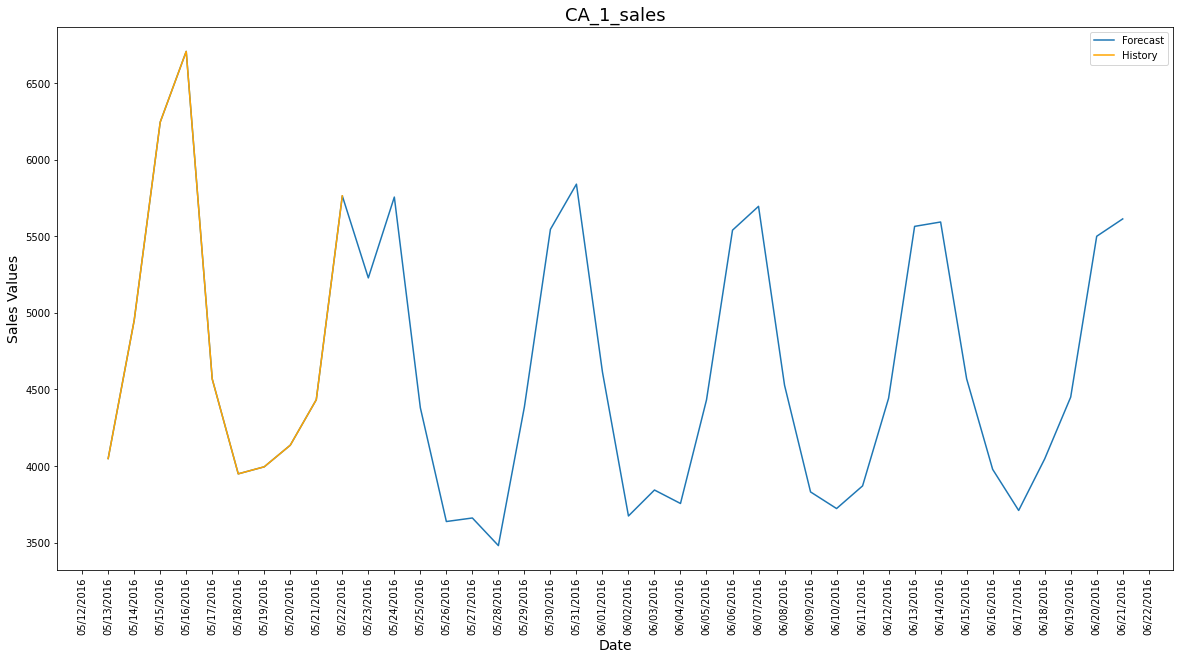

In [70]:
# Plot the data
plt.figure(figsize=(20, 10))
forecastdata.Prediction.fillna(forecastdata.History, inplace=True)
ax = sns.lineplot(x=forecastdata.index, y=forecastdata['Prediction'], label = 'Forecast', color = '#1f77b4')
ax = sns.lineplot(x=forecastdata.index, y=forecastdata['History'], label = 'History', color = '#FFA500')
# Define the date format
date_form = DateFormatter("%m/%d/%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Sales Values', fontsize=14)
ax.set_title(storename + '_sales', fontsize=18)
plt.legend(loc="best")
plt.savefig(storename+ '_sales_fore.png')